In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Part 1 : Convolution

In [3]:
def to_gray(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

In [4]:
image = cv2.imread("Images/testPattern.jpg")

img = to_gray(image)

#### Convolution for 2D images

In [19]:
def conv2D(img, kernel):
    pad = kernel.shape[0] // 2
    
    pad_img = np.pad(img, pad_width=pad, mode='constant', constant_values=0)
    output = np.zeros(shape=(img.shape[0], img.shape[1]))

    for i in range(pad, img.shape[0] + pad):
        for j in range(pad, img.shape[1] + pad):
            output[i - pad, j - pad] = np.sum(pad_img[i-pad:i+pad+1, j-pad:j+pad+1] * kernel)
    
    return output 


#### Mean filter for a given kernel size k

In [18]:
def meanFilter(img, k):
    kernel = np.ones(shape=(k, k))/(k*k)
    out = conv2D(img, kernel)
    
    return out.astype(np.uint8)


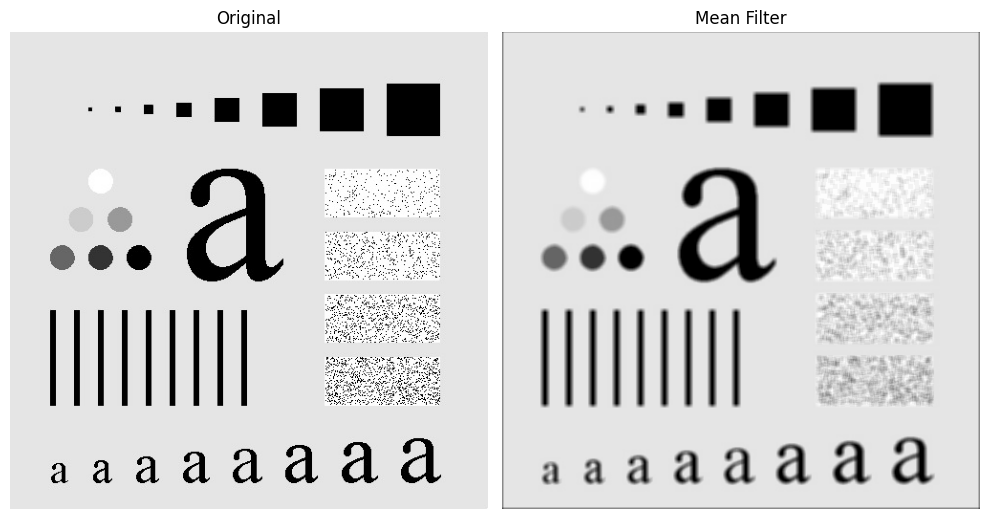

In [44]:
out = meanFilter(img, 5)
out = cv2.cvtColor(out, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Mean Filter")
plt.imshow(out)
plt.axis('off')
plt.tight_layout()



#### Time taken vs kernel size k

<function matplotlib.pyplot.show(close=None, block=None)>

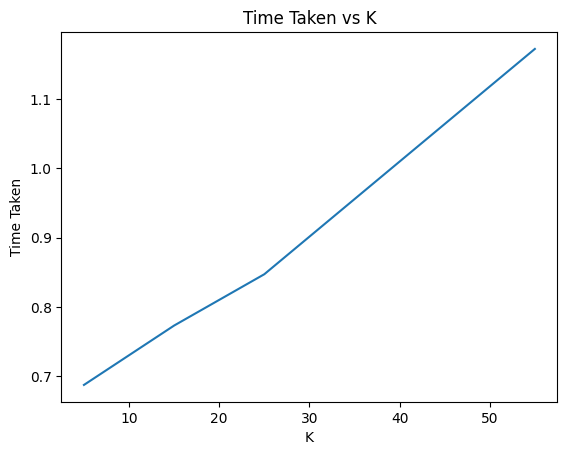

In [38]:
import time 

k = [5, 15, 25, 55]
time_taken = []

for size in k:
    start = time.time()
    meanFilter(img, size)
    end = time.time()
    time_taken.append(end-start)

plt.plot(k, time_taken)
plt.title("Time Taken vs K")
plt.xlabel("K")
plt.ylabel("Time Taken")
plt.show

From the above graph, we can see that the time taken for the operations increases with kernel size k. This is because in every iteration of our convolution, we now have to convolve our input image with a larger kernel each time. Thus the time taken to multiply our kernel with a section of the input image now takes longer. <br>

As the dimensions of the image, that is its height h and width w increase, the number of convolution operations increase and thus time taken increases.

#### Gaussian filter for a given kernel size k and sigma

In [46]:
def GaussianFilter(img, k, sigma):
    kernel = np.ones(shape=(k, k))

    for i in range(k):
        for j in range(k):
            x, y = i - k // 2, j - k // 2
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    kernel = kernel / np.sum(kernel)

    out = conv2D(img, kernel)
    
    return out.astype(np.uint8)

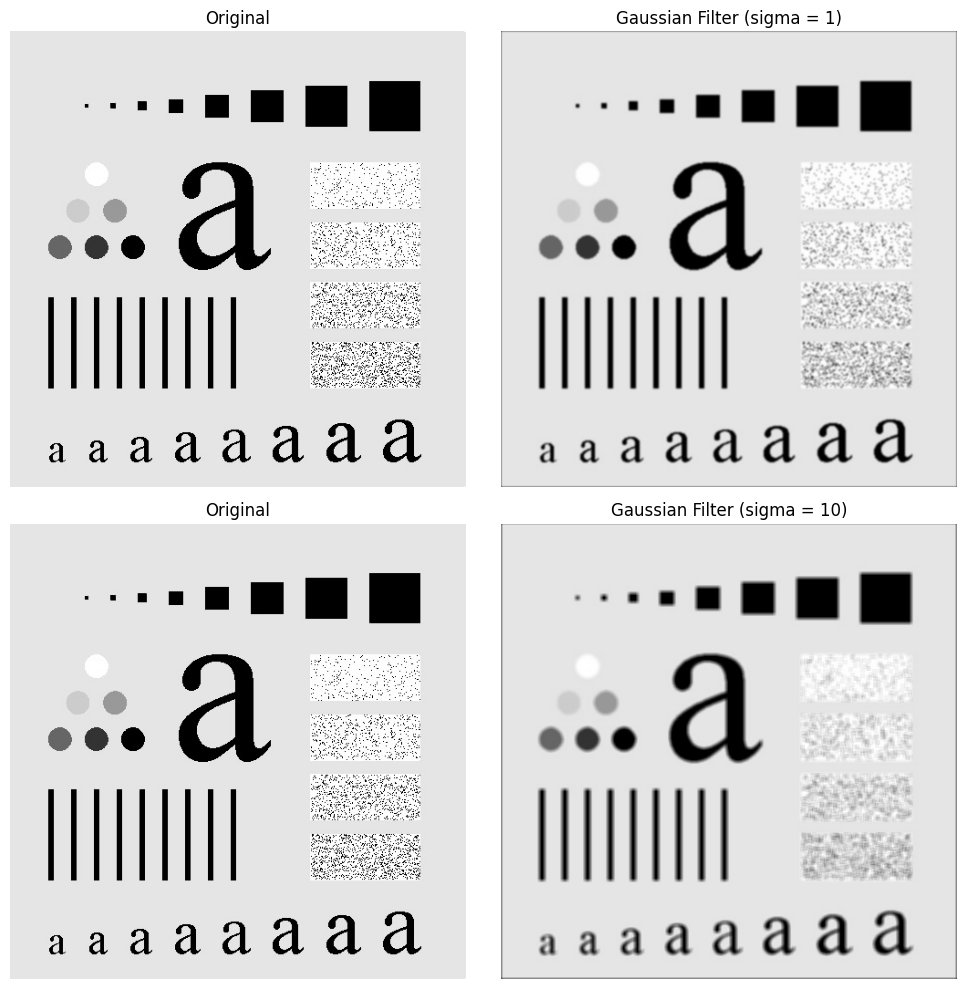

In [48]:
output = GaussianFilter(img, 5, 1)
output = cv2.cvtColor(output, cv2.COLOR_GRAY2RGB)

output1 = GaussianFilter(img, 5, 10)
output1 = cv2.cvtColor(output1, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1)
plt.title("Original")
plt.imshow(image)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Gaussian Filter (sigma = 1)")
plt.imshow(output)
plt.axis('off')


plt.subplot(2, 2, 3)
plt.title("Original")
plt.imshow(image)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Gaussian Filter (sigma = 10)")
plt.imshow(output1)
plt.axis('off')

plt.tight_layout()

#### Sigma -> $\infty$

From the kernel equation for the Gaussian kernel, we can see that as sigma tends to infinity, $e^{-(x^{2} + y^{2}) / (2 * sigma^{2})}$  tends to 1. <br>
We then normalise the kernel by dividing it by the sum of all the elements in the kernel. In this case that would be $k^{2}$, where k is the size of the kernel. <br>
This is nothing but the mean filter. Thus the bilateral filter gives results equivalent to the mean filter as sigma -> $\infty$

## Part 2: Need for Speed

In [24]:
def speedyMeanFilter(img, k):

    pad = k//2
    output = np.ones(shape=(img.shape[0], img.shape[1]))
    pad_img = np.pad(img, pad_width=pad, mode='constant', constant_values=0)

    for row in range(pad, img.shape[0] + pad):
        col = pad
        s = np.zeros(k)

        for j in range(col-pad, col+pad+1):
            s[j] = np.sum(pad_img[row-pad:row+pad+1, j:j+1])

        sum = np.sum(s)

        output[row-pad][col-pad] = sum / (k**2)
        j = 0

        for col in range(pad+1, img.shape[1]+pad):
            sum -= s[j]
            s[j] = np.sum(pad_img[row-pad:row+pad+1, col+k//2:col+k//2+1])

            sum += s[j]
            output[row-pad][col-pad] = sum / (k**2)
            j += 1

            if j >= k:
                j = 0

    return output.astype(np.uint8)
        

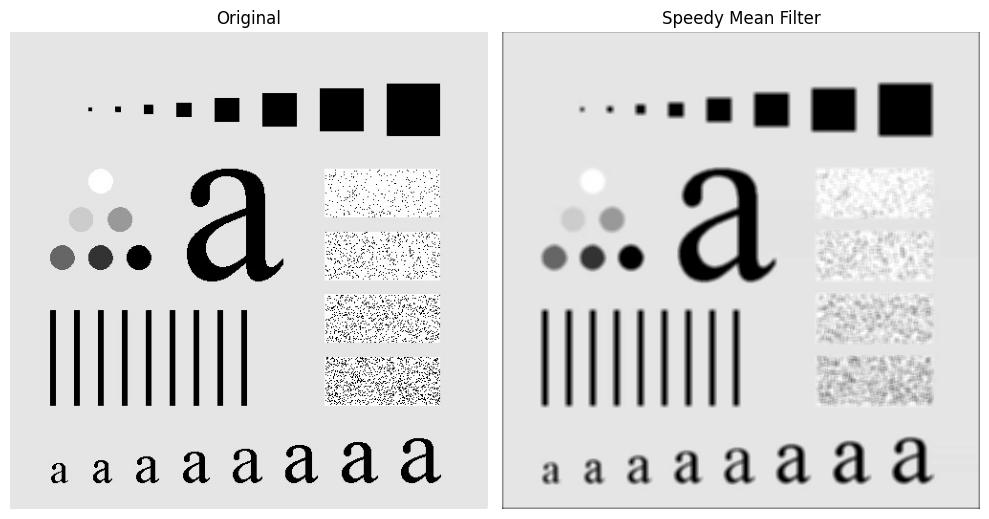

In [49]:
smean = speedyMeanFilter(img, 5)
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Speedy Mean Filter")
plt.imshow(smean, cmap='gray')
plt.axis('off')

plt.tight_layout()

#### Time vs K

<function matplotlib.pyplot.show(close=None, block=None)>

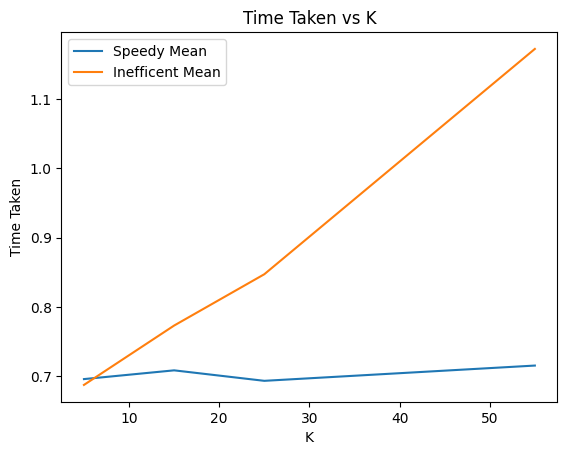

In [39]:
import time 

k = [5, 15, 25, 55]
time_taken_speed = []

for size in k:
    start = time.time()
    speedyMeanFilter(img, size)
    end = time.time()
    time_taken_speed.append(end-start)

plt.plot(k, time_taken_speed, label='Speedy Mean')
plt.plot(k, time_taken, label='Inefficent Mean')

plt.title("Time Taken vs K")
plt.xlabel("K")
plt.ylabel("Time Taken")
plt.legend()
plt.show

## Part 3: Salt and Pepper

#### 1.

The image given has black dots present. This occurs due to presence of noise as low intensity values and is called pepper noise. Thus we use the max filter to remove small intensity values or remove pepper noise.

In [51]:
def max_filter(img, k):
    pad = k // 2
    
    pad_img = np.pad(img, pad_width=pad, mode='reflect')
    output = np.ones(shape=(img.shape[0], img.shape[1]))

    for i in range(pad, img.shape[0] + pad):
        for j in range(pad, img.shape[1] + pad):
            output[i - pad, j - pad] = np.max(pad_img[i-pad:i+pad+1, j-pad:j+pad+1])

    return output.astype(np.uint8)

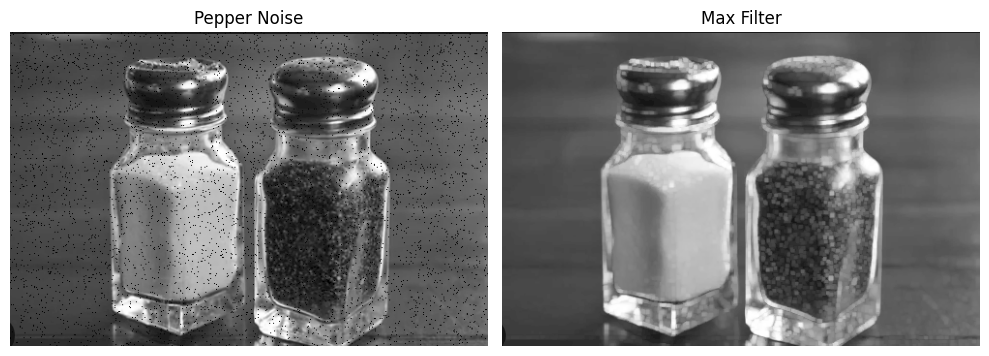

In [52]:
salt = cv2.imread("Images/salt_noise.png")
saltg = to_gray(salt)

outs = max_filter(salt, 3)
outs = cv2.cvtColor(outs, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.title("Pepper Noise")
plt.imshow(salt)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Max Filter")
plt.imshow(outs)
plt.axis('off')

plt.tight_layout()


#### 2.

The image given has white dots present all over. This occurs due to presence of noise as high intensity values and is called salt noise. Thus we use the min filter to remove large intensity values or remove salt noise.

In [53]:
def min_filter(img, k):
    pad = k // 2
    
    pad_img = np.pad(img, pad_width=pad, mode='reflect')
    output = np.ones(shape=(img.shape[0], img.shape[1]))

    for i in range(pad, img.shape[0] + pad):
        for j in range(pad, img.shape[1] + pad):
            output[i - pad, j - pad] = np.min(pad_img[i-pad:i+pad+1, j-pad:j+pad+1])

    return output.astype(np.uint8)

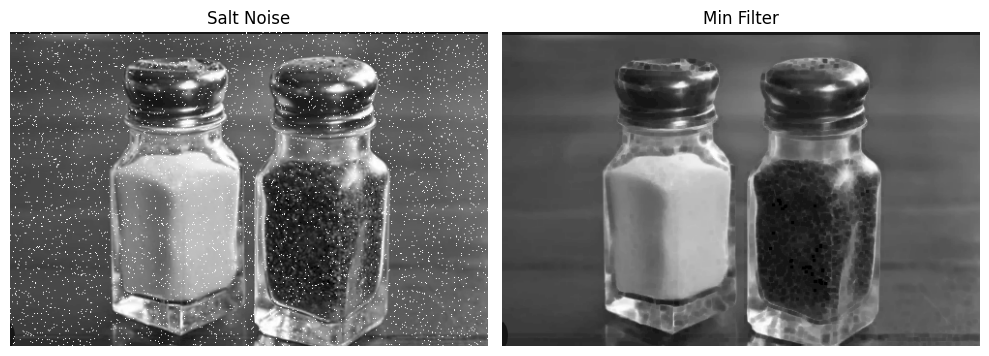

In [54]:
pepper = cv2.imread("Images/pepper_noise.png")
pepg = to_gray(pepper)

outp = min_filter(pepg, 3)
outp = cv2.cvtColor(outp, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.title("Salt Noise")
plt.imshow(pepper)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Min Filter")
plt.imshow(outp)
plt.axis('off')

plt.tight_layout()


#### 3.

The image given has black and white dots present all over. This occurs due to presence of noise as low as well as high intensity values and is called salt and pepper noise. Thus we use the median filter to remove small as well as large intensity values or remove salt and pepper noise.

In [55]:
def median_filter(img, k):
    pad = k // 2
    
    pad_img = np.pad(img, pad_width=pad, mode='reflect')
    output = np.ones(shape=(img.shape[0], img.shape[1]))

    for i in range(pad, img.shape[0] + pad):
        for j in range(pad, img.shape[1] + pad):
            output[i - pad, j - pad] = np.median(pad_img[i-pad:i+pad+1, j-pad:j+pad+1])

    return output.astype(np.uint8)

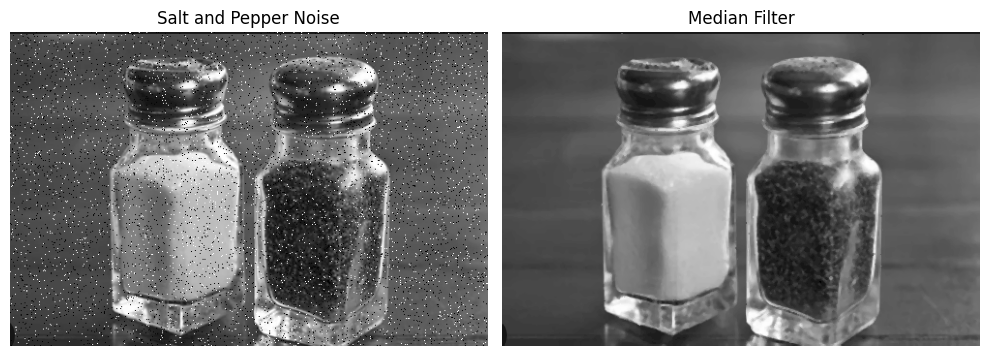

In [57]:
sp = cv2.imread("Images/salt_and_pepper_noise.png")
spg = to_gray(sp)

outsp = median_filter(spg, 3)
outsp = cv2.cvtColor(outsp, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.title("Salt and Pepper Noise")
plt.imshow(sp)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Median Filter")
plt.imshow(outsp)
plt.axis('off')

plt.tight_layout()


## Part 4: Blurry? Don't Worry

In [60]:
blurry = cv2.imread("Images/blurry_spiral.png")
blurry = to_gray(blurry)

#### Smoothened using Mean filters

In [58]:
def sharpen(img, A, k):
    smoothed = meanFilter(img, k)
    smoothed = np.clip(smoothed, 0, 255)

    edges = np.subtract(img, smoothed)

    # If A = 1, we use Unsharp Masking
    # else it is Highboost Filtering
    sharpened = img + A * edges

    return np.clip(sharpened, 0, 255)
    

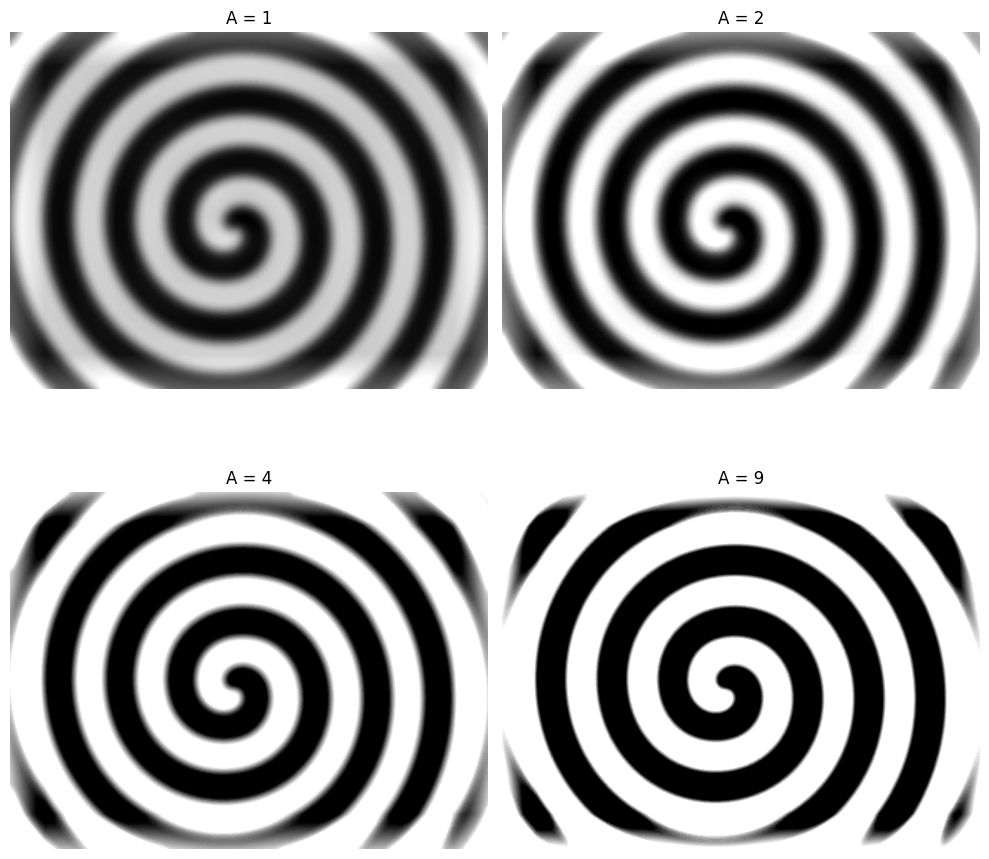

In [62]:
A = [1, 2, 4, 9]
i = 1

plt.figure(figsize=(10, 10))

for a in A:
    spiral = sharpen(blurry, a, 101)
    plt.subplot(2, 2, i)
    plt.title("A = " + str(a))
    plt.imshow(spiral, cmap='gray')
    plt.axis("off")
    i += 1

plt.tight_layout()

#### Smoothened Using Gaussian filter

In [63]:
def sharpen_g(img, A, k):
    smoothed = GaussianFilter(img, k, 20)
    smoothed = np.clip(smoothed, 0, 255)

    edges = np.subtract(img, smoothed)

    # If A = 1, we use Unsharp Masking
    # else it is Highboost Filtering
    sharpened = img + A * edges

    return np.clip(sharpened, 0, 255)

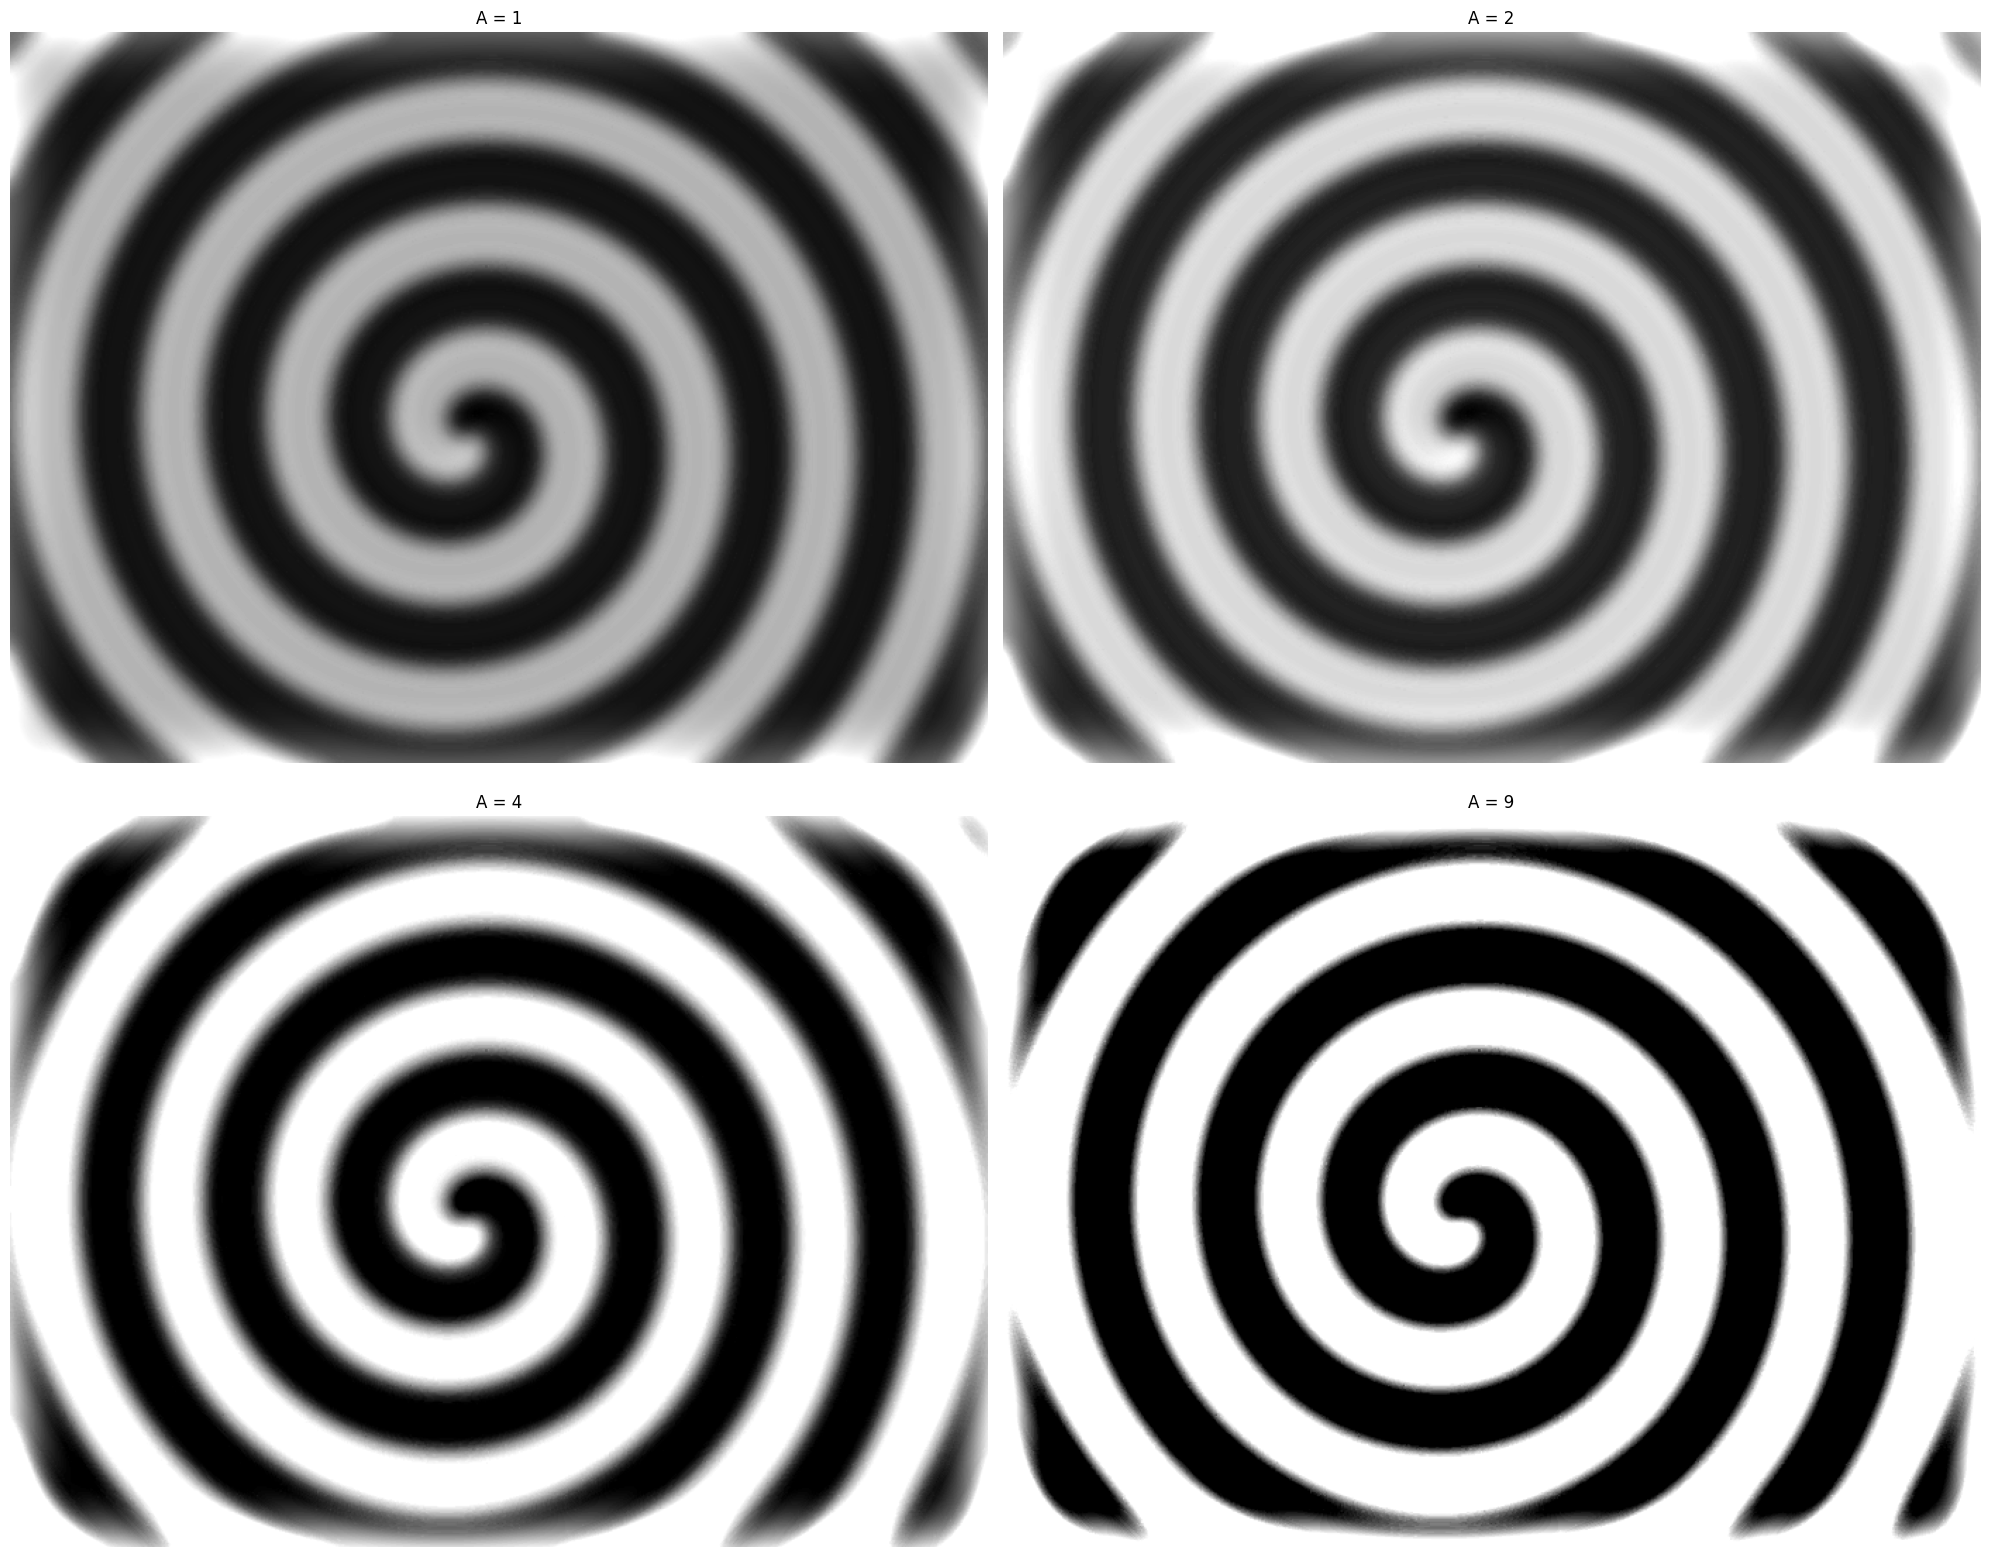

In [64]:
A = [1, 2, 4, 9]
i = 1

plt.figure(figsize=(20, 16))

for a in A:
    spiral = sharpen_g(blurry, a, 101)
    plt.subplot(2, 2, i)
    plt.title("A = " + str(a))
    plt.imshow(spiral, cmap='gray')
    plt.axis("off")
    i += 1

plt.tight_layout()

#### Observations

Gaussian Blurring preserves finer details better than Mean Blurring. Thus it is better to use Gaussian Blurring in case of High Boost Filtering where we wish to sharpen the image since the finer details in the image are preserved. Thus sharpening performed using Gaussian blurring produces better results compared to using Mean Blurring. 

## Part 5: Counting Coins

In [65]:
coins = cv2.imread("Images/coins.PNG")
coing = to_gray(coins)


### Prewitt

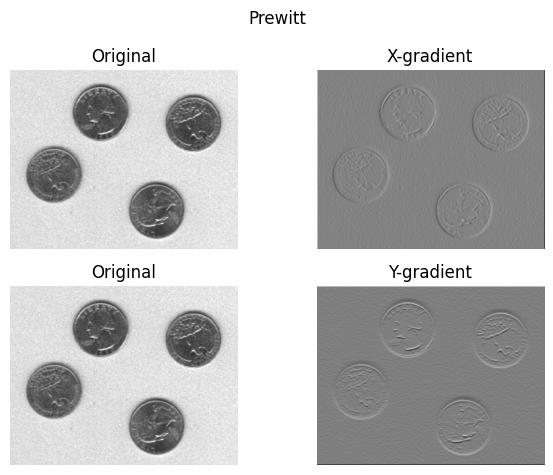

In [68]:
prewitty = np.array([[-1, -1, -1], 
                     [0, 0, 0], 
                     [1, 1, 1]])

coiny = conv2D(coing, prewitty)

prewittx = np.array([[-1, 0, 1],
                     [-1, 0, 1],
                     [-1, 0, 1]])

coinx = conv2D(coing, prewittx)

plt.suptitle('Prewitt')

plt.subplot(2, 2, 1)
plt.imshow(coins)
plt.title("Original")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(coinx, cmap='gray')
plt.title('X-gradient')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(coins,cmap = "gray")
plt.title("Original")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(coiny,cmap="gray")
plt.title("Y-gradient")
plt.axis('off')

plt.tight_layout()


### Sobel

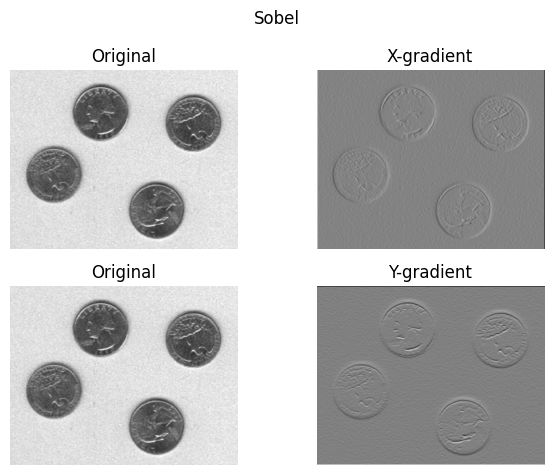

In [78]:
sobely = np.array([[1, 2, 1], 
                     [0, 0, 0], 
                     [-1, -2, -1]])

coinsy = conv2D(coing, sobely)

sobelx = np.array([[-1, 0, 1], 
                     [-2, 0, 2], 
                     [-1, 0, 1]])

coinsx = conv2D(coing, sobelx)

plt.suptitle("Sobel")

plt.subplot(2, 2, 1)
plt.title("Original")
plt.imshow(coins,cmap = "gray")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("X-gradient")
plt.imshow(coinsx,cmap="gray")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Original")
plt.imshow(coins,cmap = "gray")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Y-gradient")
plt.imshow(coinsy,cmap="gray")
plt.axis('off')

plt.tight_layout()


### Laplacian

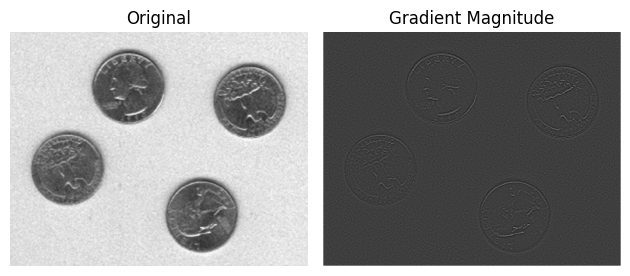

In [73]:
lap = np.array([[0, -1, 0], 
                [-1, 4, -1], 
                [0, -1, 0]])

coinl = conv2D(coing, lap)

plt.subplot(1, 2, 1)
plt.imshow(coins,cmap = "gray")
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Gradient Magnitude")
plt.imshow(coinl,cmap="gray")
plt.axis('off')

plt.tight_layout()

#### Observations

Edges in an image are locations where there is significant change in intensity values.<br>
From the above results we can see the edges in the x direction are highlighted when we apply a kernel which is equivalent to finding the gradient in the x direction.<br>
Similarly, we can see the edges in the y direction are highlighted when we apply a kernel which is equivalent to finding the gradient in the y direction.<br>

For the Laplacian filter, the kernel is equivalent to finding the gradients in both the x and y direction, thus we can observe the edges in the x and y direction after applying the Laplacian.


## Part 6: Hurry! Make it Blurry

In [74]:
tiger = cv2.imread("Images/tiger.jfif")
tiger_g = to_gray(tiger)

In [75]:
def bilateralFilter(img, k, sigma_s, sigma_r):
    output = np.ones(shape=(img.shape[0], img.shape[1]))
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):

            numerator = 0
            total_weight = 0

            radius = k // 2

            for k1 in range(max(0, i-radius), min(i+radius+1, img.shape[0])):
                for l in range(max(0, j-radius), min(j+radius+1, img.shape[1])):

                    domain = np.exp(-( ( (i-k1)**2 + (j-l)**2 ) / (2*(sigma_s**2)) ))
                    r = np.exp(-( (img[i,j] - img[k1,l])**2 ) / (2*(sigma_r**2)) )

                    weight = domain*r

                    numerator += img[k1, l] * weight
                    total_weight += weight

            output[i,j] = numerator / total_weight
    
    return output



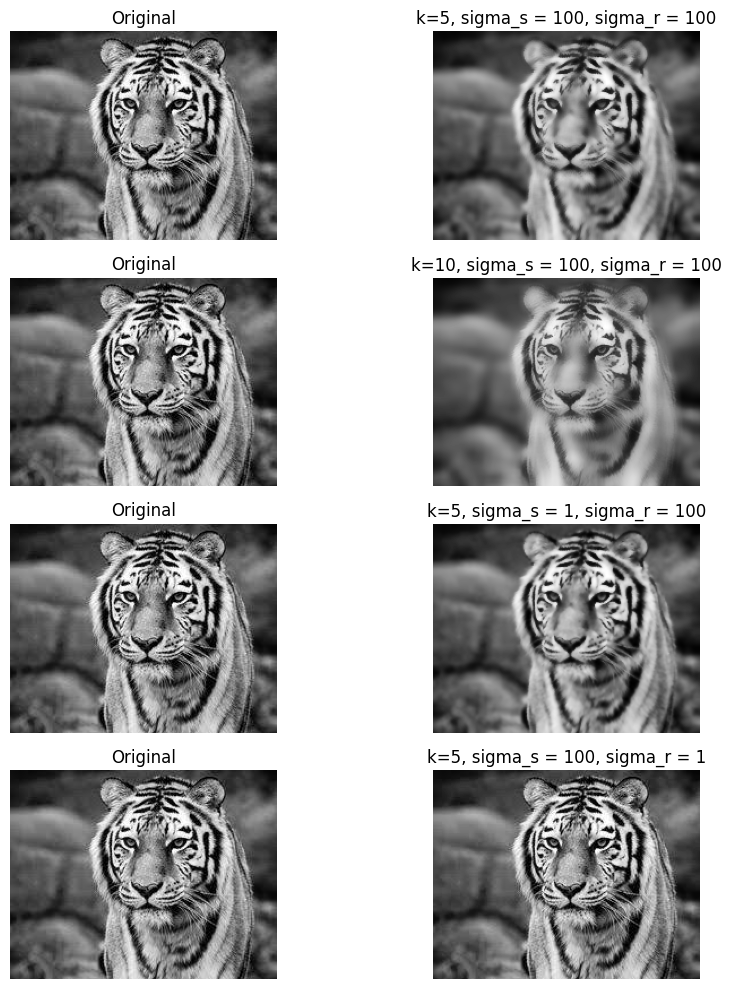

In [76]:
tigerb = bilateralFilter(tiger_g, 5, 100, 100)
tigerbK = bilateralFilter(tiger_g, 10, 100, 100)
tigerbs = bilateralFilter(tiger_g, 5, 1, 100)
tigerbr = bilateralFilter(tiger_g, 5, 100, 1)

plt.figure(figsize=(10, 10))

plt.subplot(4, 2, 1)
plt.title("Original")
plt.imshow(tiger)
plt.axis('off')

plt.subplot(4, 2, 2)
plt.title("k=5, sigma_s = 100, sigma_r = 100")
plt.imshow(tigerb, cmap='gray')
plt.axis('off')

# Changing only k
plt.subplot(4, 2, 3)
plt.title("Original")
plt.imshow(tiger)
plt.axis('off')

plt.subplot(4, 2, 4)
plt.title("k=10, sigma_s = 100, sigma_r = 100")
plt.imshow(tigerbK, cmap='gray')
plt.axis('off')

# Changing only sigma_s
plt.subplot(4, 2, 5)
plt.title("Original")
plt.imshow(tiger)
plt.axis('off')

plt.subplot(4, 2, 6)
plt.title("k=5, sigma_s = 1, sigma_r = 100")
plt.imshow(tigerbs, cmap='gray')
plt.axis('off')


# Changing only sigma_r
plt.subplot(4, 2, 7)
plt.title("Original")
plt.imshow(tiger)
plt.axis('off')

plt.subplot(4, 2, 8)
plt.title("k=5, sigma_s = 100, sigma_r = 1")
plt.imshow(tigerbr, cmap='gray')
plt.axis('off')

plt.tight_layout()

From the above images we see that changing one parameter (k, sigma_s, sigma_r), changes the blurring effect of the image. <br>
We see that increasing k (kernel size), increases the blurring. <br>
As sigma_s, that is the spatial range Gaussian increases, the larger features, such as the lines on the tiger become more blurred. <br>
As sigma_r, that is intensity range Gaussian increases, the Bilateral filter approaches Gaussian filter because the Gaussian widens and flattens and becomes nearly constant over the intensity interval.

#### Difference between Bilateral and Gaussian Filtering

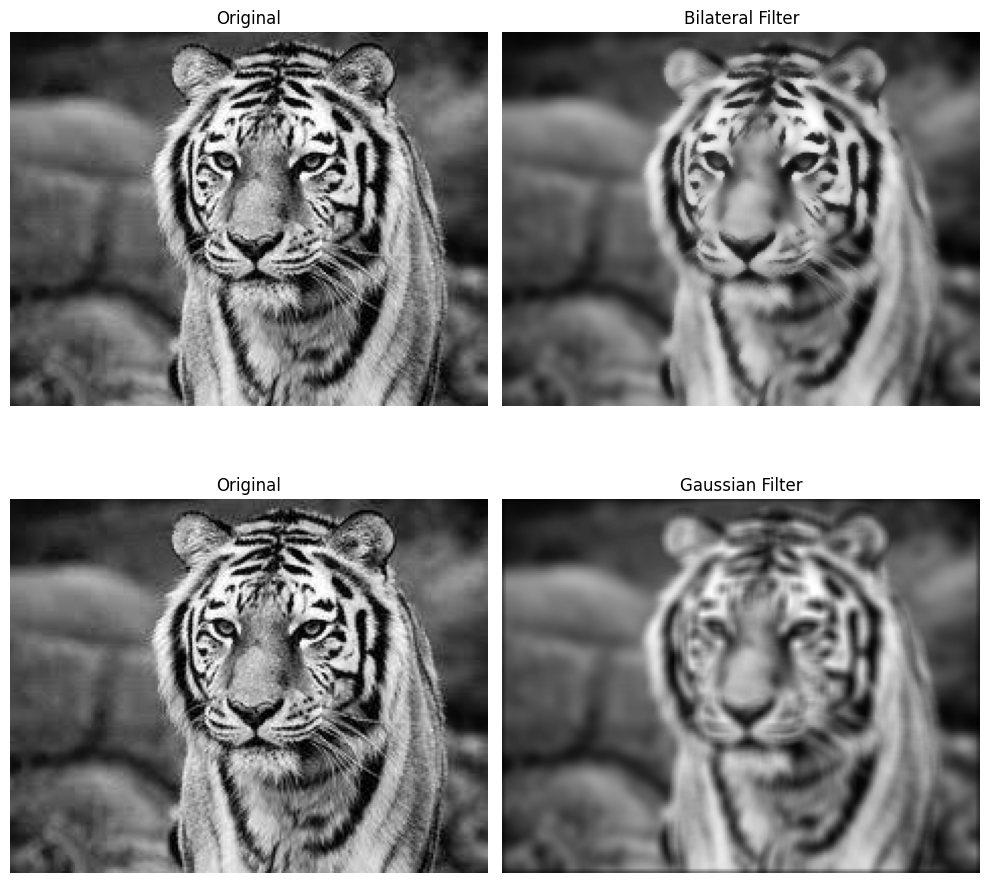

In [77]:
tiger_gaussian = GaussianFilter(tiger_g, 5, 100)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title("Original")
plt.imshow(tiger)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Bilateral Filter")
plt.imshow(tigerb, cmap='gray')
plt.axis('off')


plt.subplot(2, 2, 3)
plt.title("Original")
plt.imshow(tiger)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Gaussian Filter")
plt.imshow(tiger_gaussian, cmap='gray')
plt.axis('off')

plt.tight_layout()

From the above results we can see that the Bilateral Filter preserves edges more than the Gaussian filter and is cleaner. The finer details are more preserved in Bilateral Filtering compared to Gaussian filtering.